In [32]:
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *

In [3]:
cmip_dir = '/media/rasp/Elements/CMIP/5.625deg/'
era_dir = '/media/rasp/Elements/weather-benchmark/5.625deg/'

## Compare fields

In [23]:
var = 'temperature'
cmip = xr.open_mfdataset(f'{cmip_dir}/{var}/*.nc')
era = xr.open_mfdataset(f'{era_dir}/{var}/*.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.14 the 

In [149]:
cmip.plev

<xarray.DataArray 'plev' (plev: 10)>
array([  1000.,   5000.,  10000.,  25000.,  50000.,  60000.,  70000.,  85000.,
        92500., 100000.])
Coordinates:
  * plev     (plev) float64 1e+03 5e+03 1e+04 2.5e+04 ... 8.5e+04 9.25e+04 1e+05
Attributes:
    units:          Pa
    axis:           Z
    positive:       down
    long_name:      pressure
    standard_name:  air_pressure

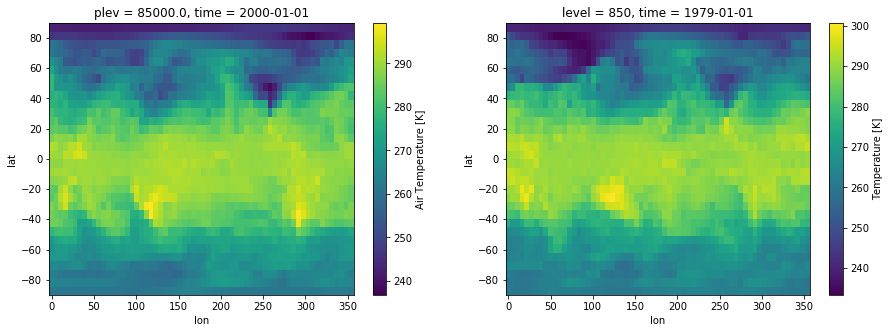

In [26]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmip.t.isel(time=0).sel(plev=8.5e4).plot(ax=ax1)
era.t.isel(time=0).sel(level=850).plot(ax=ax2)

## Compare dataloader

In [106]:
exp_id = '13-resnet_bn_dr_0.1'
datadir = '/data/stephan/WeatherBench/2.8125deg/'
# datadir = '/data/stephan/WeatherBench/5.625deg/'
model_save_dir = '/home/rasp/data/myWeatherBench/predictions/saved_models/'
pred_save_dir = '/home/rasp/data/myWeatherBench/predictions/'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = False
dropout = 0.1

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [107]:
tmp_dict = var_dict.copy()

In [108]:
tmp_dict.pop('constants')

['lsm', 'orography', 'lat2d']

In [104]:
var_dict

{'geopotential': ('z', [200, 500, 850]),
 'temperature': ('t', [200, 500, 850]),
 'u_component_of_wind': ('u', [200, 500, 850]),
 'v_component_of_wind': ('v', [200, 500, 850]),
 'constants': ['lsm', 'orography', 'lat2d']}

### A. Standard

In [79]:
datadir = era_dir

In [80]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [81]:
ds_train = ds.sel(time=slice('2010', '2014'))

In [82]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, load=False, shuffle=False
)

DG start 23:32:43.195508
DG normalize 23:32:43.244948
DG load 23:33:18.657161
DG done 23:33:18.657249


### B. CMIP

In [145]:
datadir = cmip_dir

In [146]:
var_dict = {'geopotential': ('z', [250, 500, 850]), 'temperature': ('t', [250, 500, 850]), 'u_component_of_wind': ('u', [250, 500, 850]), 'v_component_of_wind': ('v', [250, 500, 850])}

In [147]:
ds_cmip = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc') for var in var_dict.keys()])

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


KeyboardInterrupt: 

In [ ]:
ds_cmpi

In [86]:
ds_train = ds_cmip.sel(time=slice('2000', '2014'))

In [87]:
ds_train['plev'] /= 100

In [88]:
ds_train = ds_train.rename({'plev': 'level'})

In [89]:
dg_train_cmip = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, load=False, shuffle=False
)

DG start 23:35:51.632160
DG normalize 23:35:51.657199
DG load 23:35:58.153247
DG done 23:35:58.153332


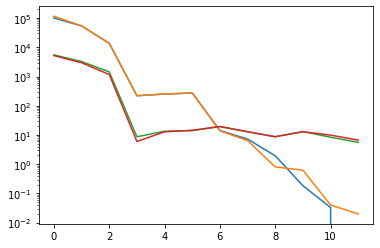

In [90]:
plt.plot(dg_train_cmip.mean)
plt.plot(dg_train.mean[:12])
plt.plot(dg_train_cmip.std)
plt.plot(dg_train.std[:12])
plt.yscale('log')

In [132]:
X, y = dg_train[100]

In [133]:
Xc, yc = dg_train_cmip[100]

In [134]:
X.shape

(32, 32, 64, 15)

In [142]:
dg_train.dt

2.0

In [143]:
dg_train_cmip.dt

12.0

In [135]:
dg_train.data.level_names

<xarray.DataArray 'level_names' (level: 15)>
array(['z_200', 'z_500', 'z_850', 't_200', 't_500', 't_850', 'u_200',
       'u_500', 'u_850', 'v_200', 'v_500', 'v_850', 'lsm', 'orography',
       'lat2d'], dtype='<U9')
Coordinates:
  * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
    level_names  (level) <U9 'z_200' 'z_500' 'z_850' ... 'orography' 'lat2d'

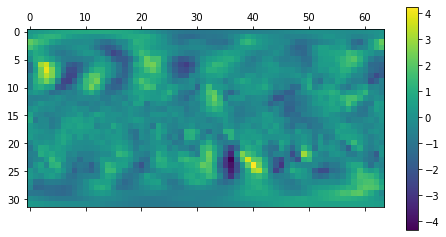

In [138]:
plt.matshow(X[-1, :, :, 9])
plt.colorbar()

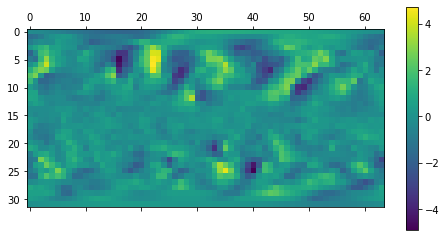

In [139]:
plt.matshow(Xc[-1, :, :, 9])
plt.colorbar()